# TASK

HuggingFace로 MNLI 모순 분류 구현하기

Task: Multi-genre Natural Language Inference (MNLI)
문제 설명:
두 개의 문장(전제(premise)와 가설(hypothesis))이 주어졌을 때, 두 문장이 서로 논리적으로 연결되어 있는지, 모순되는지, 혹은 관련이 없는지를 판별하는 문제입니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.


In [22]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer

## Dataset 준비

논리적 모순 분류 dataset을 준비하겠습니다.
Dataset은 `nyu-mll/glue`을 활용합니다.

In [23]:
glues = load_dataset("nyu-mll/glue", "mnli")
glues["train"][1]
# print(data['train']['features']['label'])
print(glues)
print(glues['train'].features['label'])

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)


어떻게 합치지

두 문장을 `premise` , `hypothesis`에 저장하고 있음
label은 names=['entailment', 'neutral', 'contradiction'] 를 저장함


# 모델 선정

테스크에 맞는 태그를 찾아서 가장 많이 사용하는 모델을 가져옴


BAAI/bge-m3 는 허깅페이스 지원안해서 안씀

http://github.com/FlagOpen/FlagEmbedding

In [24]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"


tokenizer = AutoTokenizer.from_pretrained(model_name)

# 해결 방식 설계

문장의 의미를 해석하고 관련 있음 , 관련 없음, 관련 있고 모순됨 을 구분해야한다  
토크나이저의 경우 언어 모델의 특성 상 모델에 종속적이다
그래서 AutoTokenizer.from_pretrained 로 토크나이저를 가져오는 것이라고 해석했다


https://www.sbert.net/docs/cross_encoder/training_overview.html

In [25]:
max_length = 256

# 2. 전처리 함수 정의 (수정된 버전)
def preprocess_function(data):
    # 배치 데이터에서 직접 추출
    premises = data["premise"]
    hypotheses = data["hypothesis"]
    
    model_inputs = tokenizer(
        premises,
        hypotheses,
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    
    model_inputs["labels"] = data["label"]
    return model_inputs

# 3. 전체 데이터셋에 전처리 적용
tokenized_dataset = glues.map(
    preprocess_function, 
    batched=True,
    remove_columns=glues["train"].column_names  # 원본 컬럼 제거
)

# 4. 필요한 데이터셋 분할
train_dataset = tokenized_dataset["train"]
val_matched_dataset = tokenized_dataset["validation_matched"]
val_mismatched_dataset = tokenized_dataset["validation_mismatched"]


# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')



In [26]:
print(train_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 392702
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 9796
})


In [27]:
# 토큰화 결과 자세히 확인
def inspect_tokenization(tokenizer, premises, hypotheses):
    # 한 쌍의 문장에 대해 토큰화 수행
    outputs = tokenizer(
        premises,
        hypotheses,
        padding="max_length",
        truncation=True,
        max_length=128
    )
    
    print("=== 토큰화 상세 분석 ===")
    for i in range(min(3, len(premises))):  # 처음 3개 샘플만 확인
        print(f"\n샘플 {i+1}:")
        print(f"원본 전제: {premises[i]}")
        print(f"원본 가설: {hypotheses[i]}")
        
        # 토큰 ID를 실제 토큰으로 변환하여 하나씩 출력
        tokens = [tokenizer.decode([tid]) for tid in outputs['input_ids'][i]]
        
        print("\n토큰 단위 분석:")
        for j, token in enumerate(tokens):
            if token.strip():  # 공백 토큰 제외
                print(f"위치 {j}: {token}")
                
        # 전체 디코딩된 문장도 확인
        print("\n전체 디코딩된 문장:")
        print(tokenizer.decode(outputs['input_ids'][i]))
        print("-" * 50)

# 샘플 데이터로 테스트
sample_data = glues["train"].select(range(3))
inspect_tokenization(
    tokenizer,
    sample_data["premise"],
    sample_data["hypothesis"]
)

=== 토큰화 상세 분석 ===

샘플 1:
원본 전제: Conceptually cream skimming has two basic dimensions - product and geography.
원본 가설: Product and geography are what make cream skimming work. 

토큰 단위 분석:
위치 0: [CLS]
위치 1: conceptual
위치 2: ##ly
위치 3: cream
위치 4: ski
위치 5: ##mming
위치 6: has
위치 7: two
위치 8: basic
위치 9: dimensions
위치 10: -
위치 11: product
위치 12: and
위치 13: geography
위치 14: .
위치 15: [SEP]
위치 16: product
위치 17: and
위치 18: geography
위치 19: are
위치 20: what
위치 21: make
위치 22: cream
위치 23: ski
위치 24: ##mming
위치 25: work
위치 26: .
위치 27: [SEP]
위치 28: [PAD]
위치 29: [PAD]
위치 30: [PAD]
위치 31: [PAD]
위치 32: [PAD]
위치 33: [PAD]
위치 34: [PAD]
위치 35: [PAD]
위치 36: [PAD]
위치 37: [PAD]
위치 38: [PAD]
위치 39: [PAD]
위치 40: [PAD]
위치 41: [PAD]
위치 42: [PAD]
위치 43: [PAD]
위치 44: [PAD]
위치 45: [PAD]
위치 46: [PAD]
위치 47: [PAD]
위치 48: [PAD]
위치 49: [PAD]
위치 50: [PAD]
위치 51: [PAD]
위치 52: [PAD]
위치 53: [PAD]
위치 54: [PAD]
위치 55: [PAD]
위치 56: [PAD]
위치 57: [PAD]
위치 58: [PAD]
위치 59: [PAD]
위치 60: [PAD]
위치 61: [PAD]
위치 62: [PAD]
위치 63: [P

데이터 셋 정보 확인은 이해되지 않는다  
입력 값에서 premise, hypothesis를 구분하지 않는다  

DataCollatorWithPadding 는 동적 패딩(Dynamic Padding)작업을 해줌

In [28]:
from transformers import DataCollatorForSeq2Seq
from transformers import DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [29]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # MNLI는 3개 라벨

print(model)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [30]:
# BERT 모델 부분 동결 (분류기 제외)
for param in model.bert.parameters():
    param.requires_grad = False

# 분류기 레이어만 학습 가능하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

# 학습 가능한 파라미터 확인
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"학습 가능한 파라미터: {trainable_params}")
print(f"전체 파라미터: {total_params}")
print(f"학습 가능한 파라미터 비율: {trainable_params/total_params:.2%}")

학습 가능한 파라미터: 1155
전체 파라미터: 22714371
학습 가능한 파라미터 비율: 0.01%


## 학습

마지막으로 학습 코드를 구현하겠습니다.
학습은 감정 분석과 똑같이 `training_args`를 정의하고 `Trainer`로 이전에 구현한 것들을 모두 수합하면 됩니다.

In [31]:
# 8. 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./results/minilm-mnli",
    learning_rate=2e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    # 간단한 설정
    save_steps=500,
    logging_steps=100,
  
    metric_for_best_model="accuracy",
    push_to_hub=False,
    resume_from_checkpoint=False
    # resume_from_checkpoint=True
)


In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # 기본 정확도
    accuracy = accuracy_score(labels, predictions)
    
    # 클래스별 정밀도, 재현율, F1 점수
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, 
                                                            labels=[0, 1, 2])
    
    # 가중 평균 메트릭
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted')
    
    # 혼동 행렬 계산 (로깅용이 아닌 콘솔 출력용)
    conf_mat = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)
    
    # 클래스 이름
    label_names = ['entailment', 'neutral', 'contradiction']
    
    # 결과 딕셔너리 (숫자형 값만 포함)
    results = {
        'accuracy': accuracy,
        'weighted_f1': weighted_f1,
        'weighted_precision': weighted_precision, 
        'weighted_recall': weighted_recall
    }
    
    # 클래스별 메트릭 추가
    for i, label in enumerate(label_names):
        results[f'{label}_precision'] = precision[i]
        results[f'{label}_recall'] = recall[i]
        results[f'{label}_f1'] = f1[i]
    
    return results

In [33]:

import torch

import os


# 학습 스크립트의 맨 처음에 배치
# 현재 프로세스의 CPU 친화성을 코어 6-10으로 설정

# PyTorch 내부 스레드 제어
torch.set_num_threads(4)  # 5개 스레드만 사용 (코어 6-9에 대응)

# 환경 변수로 OMP, MKL 스레드 제어
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# TrainingArguments에서 데이터로더 워커 수 설정
training_args = TrainingArguments(
    output_dir="./results",
    dataloader_num_workers=4,  # 데이터 로더 워커 수를 4개로 제한
    # 다른 훈련 인자들...
)


# 10. Trainer 초기화 및 학습
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_matched_dataset,  # 검증 데이터셋으로 matched 사용
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,


)

/var/folders/t4/5cn643kn7ls_6vyl6y51gnnm0000gn/T/ipykernel_19934/2828225048.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


마지막으로 학습하면 다음과 같습니다.

In [ ]:
# 11. 모델 학습
trainer.train()

# 12. 모델 평가 - validation_mismatched 데이터셋도 평가
mismatched_results = trainer.evaluate(val_mismatched_dataset)
print(f"Mismatched validation results: {mismatched_results}")
trainer.save_model()

Step,Training Loss
500,1.098400
1000,1.098200
1500,1.098800
2000,1.098000
2500,1.098100
3000,1.097900
3500,1.097700
4000,1.098000
4500,1.097800
5000,1.098000


학습 결과를 보면 다음과 같습니다.

보시다시피 성능이 그렇게 좋지 않습니다. 아마 더 많은 학습 시간을 요구하는 듯 합니다.

하지만 중요한 것은 data부터 모델, 학습 코드 구현까지 매우 쉽게 했다는 것입니다.


===== 종합 평가 결과 =====
데이터셋                 정확도        가중F1       가중정밀도      가중재현율     
----------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[ 207   95 3177]
 [ 181   84 2858]
 [ 157   78 2978]]
Validation Matched   0.3331     0.2118     0.3468     0.3331    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[ 207   95 3177]
 [ 181   84 2858]
 [ 157   78 2978]]
Confusion Matrix:
[[ 207   95 3177]
 [ 181   84 2858]
 [ 157   78 2978]]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[ 215   74 3174]
 [ 170   70 2889]
 [ 164   68 3008]]
Validation Mismatched 0.3349     0.2121     0.3523     0.3349    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[ 215   74 3174]
 [ 170   70 2889]
 [ 164   68 3008]]
Confusion Matrix:
[[ 215   74 3174]
 [ 170   70 2889]
 [ 164   68 3008]]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0  514  250 9032]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
Test Matched         0.0000     0.0000     0.0000     0.0000    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[   0  514  250 9032]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0  514  250 9032]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0  547  207 9093]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
Test Mismatched      0.0000     0.0000     0.0000     0.0000    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Confusion Matrix:
[[   0  547  207 9093]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0  547  207 9093]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]

===== 클래스별 상세 결과 =====

[entailment 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.3798     0.0595     0.1029    
Validation Mismatched 0.3916     0.0621     0.1072    
Test Matched         0.0000     0.0000     0.0000    
Test Mismatched      0.0000     0.0000     0.0000    

[neutral 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.3268     0.0269     0.0497    
Validation Mismatched 0.3302     0.0224     0.0419    
Test Matched         0.0000     0.0000     0.0000    
Test Mismatched      0.0000     0.0000     0.0000    

[contradiction 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.3304     0.9269

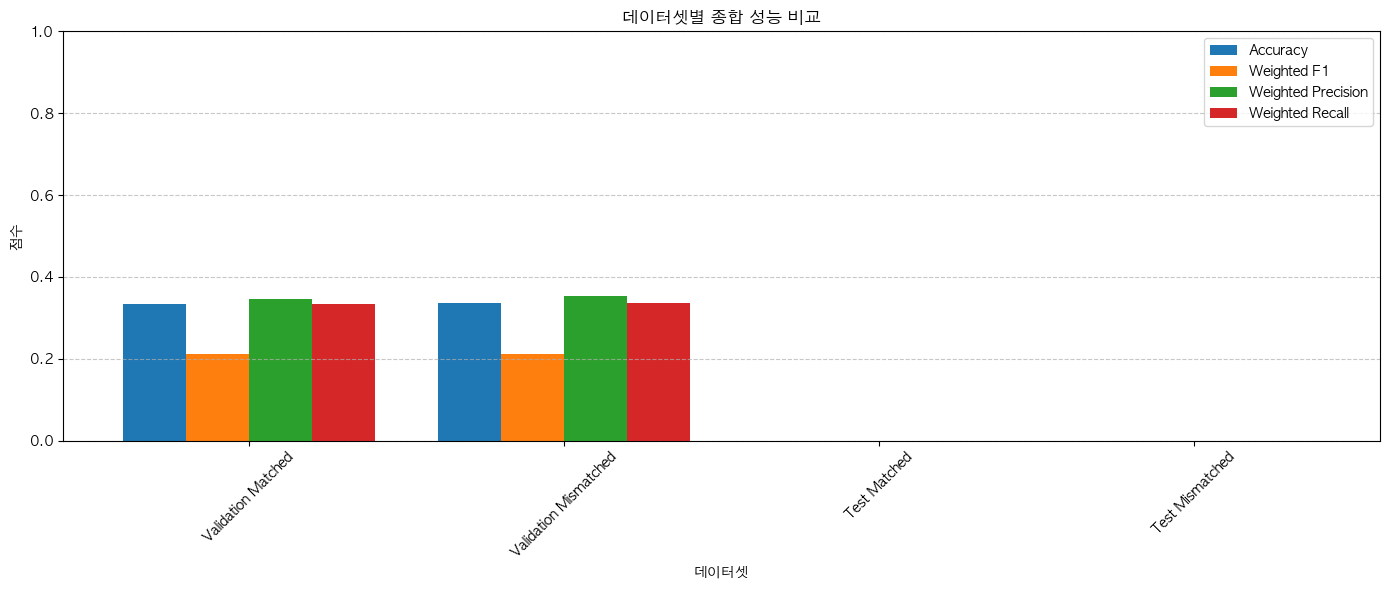

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.font_manager as fm
import platform
import os

# 저장할 상대 경로 설정
output_dir = "ft-after/visualizations"

# 경로가 존재하지 않으면 생성
os.makedirs(output_dir, exist_ok=True)

# 운영체제별 기본 폰트 설정
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'  # 윈도우의 경우 맑은 고딕
elif platform.system() == 'Darwin':  # Mac OS
    font_name = 'AppleGothic'
else:  # Linux 등 기타 OS
    font_name = 'NanumGothic'  # 나눔고딕

# 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def plot_class_metrics(eval_results, dataset_name):
    """클래스별 성능 메트릭을 시각화하는 함수"""
    class_names = ['entailment', 'neutral', 'contradiction']
    
    # 클래스별 메트릭 추출
    f1_scores = [eval_results[f'eval_{label}_f1'] for label in class_names]
    precision_scores = [eval_results[f'eval_{label}_precision'] for label in class_names]
    recall_scores = [eval_results[f'eval_{label}_recall'] for label in class_names]
    
    # 그래프 생성
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.bar(x - width, precision_scores, width, label='Precision', color='#5DA5DA')
    plt.bar(x, recall_scores, width, label='Recall', color='#FAA43A')
    plt.bar(x + width, f1_scores, width, label='F1', color='#60BD68')
    
    plt.xlabel('클래스')
    plt.ylabel('점수')
    plt.title(f'클래스별 성능 메트릭 - {dataset_name}')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(precision_scores):
        plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    for i, v in enumerate(recall_scores):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    for i, v in enumerate(f1_scores):
        plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, f'class_metrics_{dataset_name.replace(" ", "_").lower()}.png')
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    return {
        'class_names': class_names,
        'precision': precision_scores,
        'recall': recall_scores,
        'f1': f1_scores
    }

def evaluate_and_visualize_all_datasets(trainer, datasets):
    """모든 데이터셋에 대한 평가 및 시각화를 수행하는 함수"""
    print("\n===== 종합 평가 결과 =====")
    print(f"{'데이터셋':<20} {'정확도':<10} {'가중F1':<10} {'가중정밀도':<10} {'가중재현율':<10}")
    print("-" * 70)
    
    all_results = {}
    class_metrics = {}
    
    # 각 데이터셋 평가
    for name, dataset in datasets.items():
        results = trainer.evaluate(eval_dataset=dataset)
        all_results[name] = results
        
        # 결과 출력
        print(f"{name:<20} {results['eval_accuracy']:<10.4f} {results['eval_weighted_f1']:<10.4f} "
              f"{results['eval_weighted_precision']:<10.4f} {results['eval_weighted_recall']:<10.4f}")
        
        # 클래스별 메트릭 시각화
        class_metrics[name] = plot_class_metrics(results, name)
        
        # 혼동 행렬 계산 및 시각화
        predictions, labels, _ = trainer.predict(dataset)
        pred_labels = np.argmax(predictions, axis=1)
        cm = confusion_matrix(labels, pred_labels)
        print(f"Confusion Matrix:")
        print(cm)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_metrics[name]['class_names'],
                    yticklabels=class_metrics[name]['class_names'])
        plt.xlabel('예측 레이블')
        plt.ylabel('실제 레이블')
        plt.title(f'혼동 행렬 - {name}')
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
        plt.savefig(output_path, dpi=300)
        plt.close()
    
    # 클래스별 F1 점수 비교 (모든 데이터셋)
    plt.figure(figsize=(15, 6))
    
    # 데이터셋별로 클래스 F1 점수 비교 그래프 생성
    dataset_names = list(datasets.keys())
    class_names = class_metrics[dataset_names[0]]['class_names']
    x = np.arange(len(class_names))
    width = 0.8 / len(dataset_names)
    
    for i, dataset_name in enumerate(dataset_names):
        offset = (i - len(dataset_names)/2 + 0.5) * width
        plt.bar(x + offset, class_metrics[dataset_name]['f1'], width, 
                label=dataset_name)
    
    plt.xlabel('클래스')
    plt.ylabel('F1 점수')
    plt.title('모든 데이터셋의 클래스별 F1 점수 비교')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'all_datasets_f1_comparison.png')
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    # 데이터셋별 주요 메트릭 비교
    metrics = ['eval_accuracy', 'eval_weighted_f1', 'eval_weighted_precision', 'eval_weighted_recall']
    metric_names = ['Accuracy', 'Weighted F1', 'Weighted Precision', 'Weighted Recall']
    
    plt.figure(figsize=(14, 6))
    x = np.arange(len(dataset_names))
    width = 0.8 / len(metrics)
    
    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * width
        values = [all_results[name][metric] for name in dataset_names]
        plt.bar(x + offset, values, width, label=metric_names[i])
    
    plt.xlabel('데이터셋')
    plt.ylabel('점수')
    plt.title('데이터셋별 종합 성능 비교')
    plt.xticks(x, dataset_names, rotation=45)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'dataset_comparison.png')
    plt.savefig(output_path, dpi=300)
    
    # 각 클래스별 상세 결과표 출력
    print("\n===== 클래스별 상세 결과 =====")
    for cls in class_names:
        print(f"\n[{cls} 클래스 결과]")
        print(f"{'데이터셋':<20} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
        print("-" * 55)
        for name in dataset_names:
            idx = class_names.index(cls)
            print(f"{name:<20} {class_metrics[name]['precision'][idx]:<10.4f} "
                  f"{class_metrics[name]['recall'][idx]:<10.4f} "
                  f"{class_metrics[name]['f1'][idx]:<10.4f}")
    
    print(f"\n평가 결과 시각화 파일이 {output_dir} 디렉토리에 생성되었습니다:")
    print("1. 각 데이터셋별 클래스 메트릭 그래프 (class_metrics_*.png)")
    print("2. 각 데이터셋별 혼동 행렬 (confusion_matrix_*.png)")
    print("3. 모든 데이터셋의 클래스별 F1 점수 비교 (all_datasets_f1_comparison.png)")
    print("4. 데이터셋별 종합 성능 비교 (dataset_comparison.png)")
    
    return all_results, class_metrics

# 사용 예시
datasets = {
    "Validation Matched": val_matched_dataset, 
    "Validation Mismatched": val_mismatched_dataset,
    # 테스트는 안됨
    # "Test Matched": test_matched_dataset,
    # "Test Mismatched": test_mismatched_dataset
}

# 모든 데이터셋 평가 및 시각화
results, class_metrics = evaluate_and_visualize_all_datasets(trainer, datasets)


# 돌리기 전

[image1](./ft/visualizations/class_metrics_validation_matched.png)
![image2](./ft/visualizations/class_metrics_validation_mismatched.png)
![image3](./ft/visualizations/confusion_matrix_validation_matched.png)
![image4](./ft/visualizations/confusion_matrix_validation_mismatched.png)
